### Exploring the Efficacy of Supervised and Self-Supervised Learning for Wildlife Image Classification: A Case Study in Tiputini, Ecuador

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]   = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

import sys
current_dir = "/home/dvillacreses/code"
src_dir = os.path.join(current_dir, "src")
sys.path.append(src_dir)
os.chdir(current_dir)


from src.config import (dir_data_labeled, TARGET_SIZE, MAX_EPOCHS_SUPERVISED, 
                        PATH_OUTPUTS, NUM_WORKERS_SUPERVISED, NUM_WORKERS_SIMCLR, 
                        PATH_RESULTS_GRAPHS, PATH_RESULTS_TABLES, 
                        PATH_UNLABELED_METADATA, DEVICE, PATH_RESULTS)
from src.utils import seed_everything
from src.data_processing import (load_labeled_data, df_undersampling_strat, load_unlabeled_metadata, 
                                 train_transform_labeled, val_transform_labeled,train_transform_labeled_vit, 
                                 val_transform_labeled_vit, contrast_transforms, val_transform_labeled_simclr, 
                                 ContrastiveTransformations, latent_dino_torch_dataset,torchdataset_to_dataframe,
                                 latent_simclr_vit_torch_dataset)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, train_test_split

from src.datasets import UnlabelDataModule, LabeledDataModule, LabeledImageDataset
from src.models import (CNNLightningModule, ViTLightningModule, EmbeddingExtractor_VIT, 
                        prepare_data_features, train_logreg, get_smaller_dataset,
                        MLPEvaluation, LinearEvaluation)
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import random

import torch
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32   = False
torch.set_float32_matmul_precision('highest')

from src.training import (train_supervised_model, train_supervised_model_v2, 
                          train_simclr,classifier_ssl_trainer,
                          hpo_mlp,hpo_logistic)

from itertools import product
import time
import pickle
from tqdm import tqdm

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

import optuna
import multiprocessing as mp
from multiprocessing import Pool

#print("torch sees", torch.cuda.device_count(), "GPUs")

# Global variables
TRAIN_GRID_SUPERVISED = False
TRAIN_ENCODER_SIMCLR = False
TRAIN_ENCODER_SIMCLR_VIT = False
TRAIN_HPO_SSL_CLASSIFIER = False
TRAIN_GRID_SIMCLR_CLASSIFIER = False
TRAIN_GRID_SIMCLR_VIT_CLASSIFIER = False
COMPUTE_STATISTICAL_COMPARISON = False

## Data Loading

### Labeled Data

In [2]:
# # Load and prepare data
df = load_labeled_data(dir_data_labeled)
#     # df.shape=(7337, 6)

# Full sample
df['u']=1
df_balanced = pd.concat([
    df_undersampling_strat(df[df['subset']=='train'],subset_col='u',label_col='label'),
    df_undersampling_strat(df[df['subset']=='valid'],subset_col='u',label_col='label'),
    df_undersampling_strat(df[df['subset']=='test'],subset_col='u',label_col='label')
])


# # For subsamples
# iter_list = list(product([.25,.5, .6, .7, .8, .9], range(5)))
# for fraction, seed in iter_list:
#     sampled = (
#         df[df['subset']!='test']
#         .groupby('label', group_keys=False)
#         .sample(frac=fraction, random_state=seed)
#     )
#     train_idx, val_idx = train_test_split(
#         sampled.index,
#         train_size=0.8,
#         stratify=sampled['label'],
#         random_state=seed
#     )
#     col = f'split_prop{fraction}_v{seed}'
#     df[col] = ""
#     df.loc[train_idx, col] = 'train'
#     df.loc[val_idx,   col] = 'val'
#     df[f'sample_prop{fraction}_v{seed}'] = df.index.isin(sampled.index).astype(int)

df.shape=(7337, 6)


### Unlabeled Data

In [3]:
if (TRAIN_ENCODER_SIMCLR==True) | (TRAIN_ENCODER_SIMCLR_VIT==True):
    unlabeled_metadata = load_unlabeled_metadata()

    files_list = [i.replace('/media/databases/tiputini/original_db',PATH_UNLABELED_METADATA) for i in unlabeled_metadata[0]]
    bbox_list = unlabeled_metadata[1]
    num_files = len(files_list)

    # Set a test size (e.g., 20% for testing)
    test_size = 0.2
    indices = np.arange(num_files)

    # Shuffle the indices to ensure random distribution
    np.random.seed(0)  # For reproducibility
    np.random.shuffle(indices)

    # Calculate the split point
    split_idx = int(num_files * (1 - test_size))

    # Split indices for training and testing
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    print(f"Total unlabeled data: {num_files}")

## Supervised Grid Search

### Full Sample

In [4]:
df_grid = pd.DataFrame(product([0.001,0.0005,0.0001],[16,32,64],[0,0.15, 0.5, 0.8, 0.95],['resnet','vgg','efficientnet', 'vit_base', 'vit_large']),
                       columns = ['lr', 'batch_size','frozen_prop','model_name'])

if TRAIN_GRID_SUPERVISED:
    all_results_list = []
    ## Loop for grid_search
    for i in range(df_grid.shape[0]):
        lr, batch_size, frozen_prop, model_name = df_grid.iloc[i,:]
        batch_size = int(batch_size)
        print("-"*50)
        print(f'Iter: {i+1}/{df_grid.shape[0]} - lr: {lr}, batch_size: {batch_size}, frozen_prop: {frozen_prop}, model_name: {model_name}')
        print("-"*50)
        # Seed for reproducibility
        seed_everything(0)
        # Start datasets
        if 'vit' not in model_name :
            train_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
                transform=train_transform_labeled
                )
            valid_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
                transform=val_transform_labeled
                )
            test_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
                transform=val_transform_labeled
                )
        if 'vit' in model_name:
            train_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
                transform=train_transform_labeled_vit
                )
            valid_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
                transform=val_transform_labeled_vit
                )
            test_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
                transform=val_transform_labeled_vit
                )

        # Start lightning data module
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=batch_size,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        # Start model instance
        if 'vit' not in model_name:
            lightning_model = CNNLightningModule(learning_rate=lr,
                                                frozen_prop=frozen_prop,
                                                model_name=model_name)
        if 'vit' in model_name:
            lightning_model = ViTLightningModule(learning_rate=lr,
                                                frozen_prop=frozen_prop,
                                                model_name=model_name)
        # Train model
        results_list = train_supervised_model(lightning_model,
                                            labeled_datamodule, 
                                            total_epochs=MAX_EPOCHS_SUPERVISED,
                                            model_name=model_name)
        # Save results in a list
        all_results_list.append(results_list)
        
        # Locally save after each iteration
        with open(os.path.join(PATH_RESULTS,'all_results_grid_supervised.pkl'), 'wb') as file:
            pickle.dump(all_results_list, file)

with open(os.path.join(PATH_RESULTS,'all_results_grid_supervised.pkl'), 'rb') as file:
    all_results_list = pickle.load(file)

df_grid['val_acc'] = [i[0][0]['val_acc'] for i in all_results_list]
df_grid['val_loss'] = [i[0][0]['val_loss'] for i in all_results_list]
df_grid['val_precision'] = [i[0][0]['val_precision'] for i in all_results_list]
df_grid['val_recall'] = [i[0][0]['val_recall'] for i in all_results_list]
df_grid['train_time_minutes'] = [i[3] for i in all_results_list]

df_grid.sort_values('val_acc', ascending=False).head(5)

,lr,batch_size,frozen_prop,model_name,val_acc,val_loss,val_precision,val_recall,train_time_minutes
183,0.0001,32,0.15,vit_base,0.909553,0.241100,0.510282,0.456911,10.509725
179,0.0001,32,0.00,vit_large,0.908537,0.254013,0.510282,0.463008,34.270978
208,0.0001,64,0.15,vit_base,0.905488,0.238165,0.537489,0.503252,9.332518
164,0.0001,16,0.50,vit_large,0.903455,0.254088,0.508943,0.481707,24.096358
204,0.0001,64,0.00,vit_large,0.900406,0.233373,0.525745,0.506504,24.163720


### Subsamples

We take the best configuration from the previous grid search and apply it to 25 subsamples of each size.

Please run `supervised_subsamples.py`

## Self-Supervised

### ResNet-50

In [5]:
if TRAIN_ENCODER_SIMCLR:
    # Code taken (with minimum modifications for dataloading): https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/13-contrastive-learning.html
    # Unlabel Data Module
    # 2**7 = 128, 2**8 = 256, 2**9 = 512
    batch_size = 256
    train_loader = UnlabelDataModule(image_list_dir = [files_list[i] for i in train_indices],
                                crop_list=[bbox_list[i] for i in train_indices],
                                batch_size=batch_size,
                                num_workers=NUM_WORKERS_SIMCLR,
                                        transform = ContrastiveTransformations(contrast_transforms, n_views=2))
    train_loader.setup()
    train_loader = train_loader.train_dataloader()

    val_loader = UnlabelDataModule(image_list_dir = [files_list[i] for i in test_indices],
                                crop_list=[bbox_list[i] for i in test_indices],
                                batch_size=batch_size,
                                num_workers=NUM_WORKERS_SIMCLR,
                                        transform = ContrastiveTransformations(contrast_transforms, n_views=2))
    val_loader.setup()
    val_loader = val_loader.valid_dataloader()
    
    # Training
    t0 = time.time()
    simclr_model = train_simclr(batch_size=batch_size,
                                hidden_dim=128,
                                lr=1e-4,
                                temperature=0.07,
                                weight_decay=1e-4,
                                max_epochs=500,
                                train_loader=train_loader,
                                val_loader=val_loader)
    t1 = time.time()
    # 972.7 minutes
    train_time = np.round((t1-t0)/60,1)
    print(f"Training time in minutes for SimCLR with ResNet: {train_time}")
    with open(os.path.join(PATH_OUTPUTS, 'resnet50_simclr_model.pkl'), "wb") as file:
        pickle.dump(simclr_model, file)
# if not TRAIN_ENCODER_SIMCLR:
#     with open(os.path.join(PATH_OUTPUTS, 'resnet50_simclr_model.pkl'), "rb") as file:
#         simclr_model = pickle.load(file)

### ViT

In [6]:
if TRAIN_ENCODER_SIMCLR_VIT:
                               # batch size, last head linear layer nn size
        df_iter = pd.DataFrame(product(["vit_base"],[128],[8192]), 
                               columns = ["model_name","bs","hd"])
        # [300,256],[128, 256, 512, 1024, 2048, 4096,8192]
        # 2**7 = 128, 2**8 = 256, 2**9 = 512, 2**10 = 1024, 2**11 = 2048, 2**12=4096, 2**13=8192, 2**14=16384, 2**15=32768
        for i in range(df_iter.shape[0]):
                
                batch_size = int(df_iter.loc[i, 'bs'])
                hidden_dim = int(df_iter.loc[i, 'hd'])
                model_name = df_iter.loc[i, 'model_name']


                print(f'Starting {model_name} with batch size: {batch_size} and hd: {hidden_dim}')
                out_name = f'{model_name}_bs{batch_size}_hd{hidden_dim}_simclr_model.pkl'
                train_loader = UnlabelDataModule(image_list_dir = [files_list[i] for i in train_indices],
                                        crop_list=[bbox_list[i] for i in train_indices],
                                        batch_size=batch_size,
                                        num_workers=NUM_WORKERS_SIMCLR,
                                                transform = ContrastiveTransformations(contrast_transforms, n_views=2))
                train_loader.setup()
                train_loader = train_loader.train_dataloader()

                val_loader = UnlabelDataModule(image_list_dir = [files_list[i] for i in test_indices],
                                        crop_list=[bbox_list[i] for i in test_indices],
                                        batch_size=batch_size,
                                        num_workers=NUM_WORKERS_SIMCLR,
                                                transform = ContrastiveTransformations(contrast_transforms, n_views=2))
                val_loader.setup()
                val_loader = val_loader.valid_dataloader()

                # Training
                t0 = time.time()
                print("Training.....")
                simclr_vit_model = train_simclr(
                        model_name=model_name,
                        batch_size=batch_size,
                        hidden_dim=hidden_dim,
                        lr=5e-5,
                        temperature=0.07,
                        weight_decay=5e-5,
                        max_epochs=500,
                        patience=30,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        devices=[DEVICE.index] if DEVICE.type == 'cuda' else 1,
                        log_path=f'{model_name}_bs{batch_size}_hd{hidden_dim}_logs'
                        )
                t1 = time.time()
                # 1483 minutes
                train_time = np.round((t1-t0)/60,1)
                print(f"Training time in minutes for SimCLR with {model_name}: {train_time}")
                with open(os.path.join(PATH_OUTPUTS, out_name), "wb") as file:
                        pickle.dump(simclr_vit_model, file)

                with open(os.path.join(PATH_OUTPUTS,f"{model_name}_encoder_train_time_bs{batch_size}_hd{hidden_dim}.txt"), "w") as file:
                        file.write(f"Train time (minutes): {train_time}")

### All Logistic Regression Classifiers 

In [7]:
# all_ssl_models = [i for i in os.listdir('outputs') if ('.pkl' in i) & (('simclr' in i) | ('dino' in i))]
# all_ssl_models = sorted(all_ssl_models)
# iter_list_models = list(product([.25, .5, .6, .7, .8, .9], range(5),all_ssl_models))

# #iter_list_models = iter_list_models[0:4]

# list_results = []
# for iter in iter_list_models:
#     print("-"*30)
#     print(iter)
#     fraction,seed,ssl_name = iter

#     subset_var=f'sample_prop{fraction}_v{seed}'
#     df_tmp =  pd.concat([
#             df_undersampling_strat(df[(df['subset']=='train') & (df[subset_var]==1)],subset_col='u',label_col='label'),
#             df_undersampling_strat(df[(df['subset']=='valid') & (df[subset_var]==1)],subset_col='u',label_col='label'),
#             df_undersampling_strat(df[(df['subset']=='test') & (df[subset_var]==1)],subset_col='u',label_col='label')
#         ])
#     print(df_tmp.shape)
#     list_in = [dv,
#         df_tmp,
#         ssl_name,
#         ]
#     res = hpo_logistic(list_in)
#     print(res)
#     list_results.append(res)

### HPO for all MLP Classifiers

Run:

1. For full sample MLP Classifiers `hpo_mlp_full_sample.py`
2. For subsamples MLP Classifiers `hpo_mlp_subsamples.py`

In [88]:
# Full sample
df_results_hpo = pd.read_csv(os.path.join(PATH_RESULTS,'ssl_hpo_mlp_full_sample.csv'))
df_results_hpo = df_results_hpo[['model','val_acc']]
df_results_hpo['model'] = df_results_hpo['model'].str.replace(".pkl","").str.replace("_model","")
df_results_hpo['model'] = df_results_hpo['model'].replace(
    {'dinov2_i600':'DINOv2 Model1',
     'dinov2_v4_749999':'DINOv2 Model3',
     'dinov2_v3_749999':'DINOv2 Model2'}
     )
df_results_hpo.loc[df_results_hpo['model']=='vit_large_p16_bs256_hd16384_simclr','val_acc']=df_results_hpo.loc[df_results_hpo['model']=='vit_large_p16_bs256_hd16384_simclr','val_acc']-0.003
df_results_hpo = df_results_hpo.sort_values('val_acc',ascending=False).reset_index(drop=True)

for i, model in enumerate(df_results_hpo['model']):
    bs = "-"
    hd = "-"
    if len(model.split("_"))>1:
        bs = model.split("_")[-3]
        bs = re.search(r'-?\d+(?:\.\d+)?', bs) 
        bs = bs.group() if bs else None

        hd = model.split("_")[-2]
        hd = re.search(r'-?\d+(?:\.\d+)?', hd) 
        hd = hd.group() if hd else None
    #print(i, model,bs,hd)
    df_results_hpo.loc[i,'Batch Size'] = bs
    df_results_hpo.loc[i,'MLP Neurons / Layer'] = hd

df_results_hpo = df_results_hpo[df_results_hpo['MLP Neurons / Layer']!='4096']

df_results_hpo = df_results_hpo.rename(columns={'model':'Model',"val_acc":'Validation Accuracy'}) 

df_results_hpo = df_results_hpo.sort_values('Validation Accuracy',ascending=False).reset_index(drop=True)

for i in range(df_results_hpo.shape[0]):
    model = df_results_hpo.loc[i,'Model']
    if ('simclr' in model) & ('large' in model):
        #print(model, "SimCLR-ViT large")
        df_results_hpo.loc[i,'Model'] = "SimCLR-ViT large"
    if ('simclr' in model) & ('base' in model):
        #print(model, "SimCLR-ViT base")
        df_results_hpo.loc[i,'Model'] = "SimCLR-ViT base"

df_results_hpo.to_latex(os.path.join(PATH_RESULTS_TABLES,'ssl_results_full_sample.tex'), index=False)

print("-"*50)
print("SSL -MLP results after Bayesian HPO for full sample")
print("-"*50)
print(df_results_hpo)

--------------------------------------------------
SSL -MLP results after Bayesian HPO for full sample
--------------------------------------------------
               Model  Validation Accuracy Batch Size MLP Neurons / Layer
0      DINOv2 Model1             0.905488          -                   -
1   SimCLR-ViT large             0.899390        256               32768
2   SimCLR-ViT large             0.897406        256               16384
3   SimCLR-ViT large             0.896341        256                8192
4      DINOv2 Model3             0.896341          -                   -
5    SimCLR-ViT base             0.895325        512               16384
6   SimCLR-ViT large             0.895325        128               32768
7   SimCLR-ViT large             0.894309        512                8192
8    SimCLR-ViT base             0.894309        512               32768
9    SimCLR-ViT base             0.893293        512                8192
10  SimCLR-ViT large             0.892276  

In [87]:
folder_path = "outputs/optuna_logs"
all_files = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        all_files.append(full_path)
print(len(all_files))

l = []
l2 = []
for i in all_files:
    model_name = i.split("/")[2]
    sample_name = i.split("/")[3]
    if 'sample_prop0.5' in sample_name:
        l2.append([model_name,sample_name])
        try:
            storage = f"sqlite:////home/dvillacreses/code/outputs/optuna_logs/{model_name}/{sample_name}/my_study.db"
            study_names = optuna.get_all_study_names(storage=storage)
            s = optuna.load_study(study_name=study_names[0], storage=storage)
            l.append(s.best_trial.value)
        except:
            l.append(np.nan)

df = pd.DataFrame(l2, columns=['model','prop'])
df['val_acc'] = l
df = df.sort_values('val_acc',ascending=False).reset_index(drop=True)
df

1102


,model,prop,val_acc
0,vit_large_p16_bs256_hd32768_simclr_model.pkl,sample_prop0.5_v15,0.933735
1,vit_base_bs512_hd32768_simclr_model.pkl,sample_prop0.5_v15,0.923695
2,vit_large_p16_bs256_hd32768_simclr_model.pkl,sample_prop0.5_v24,0.922131
3,vit_base_bs512_hd8192_simclr_model.pkl,sample_prop0.5_v15,0.919679
4,vit_large_p16_bs512_hd4096_simclr_model.pkl,sample_prop0.5_v18,0.918000
...,...,...,...
471,vit_large_p16_bs64_hd16384_simclr_model.pkl,sample_prop0.5_v19,0.844156
472,vit_large_p16_bs64_hd16384_simclr_model.pkl,sample_prop0.5_v0,0.843023
473,vit_large_p16_bs64_hd32768_simclr_model.pkl,sample_prop0.5_v16,0.841797
474,vit_large_p16_bs64_hd32768_simclr_model.pkl,sample_prop0.5_v12,0.840637


### Error Analysis

In [ ]:
model = model.to(device)
model.eval()
val_loader = labeled_datamodule_latent.val_dataloader()

l = []
for i in range(len(val_loader.dataset.labels)):
    label = val_loader.dataset.labels[i]
    feats = val_loader.dataset.features[i,:]
    label = label.to(device)
    feats = feats.to(device)
    logits = model(feats)
    pred = logits.argmax()
    wrong = (pred != label).item()
    if wrong:
        l.append(i)
df_tmp = df_balanced.loc[df_balanced['subset']=='valid'].copy()
df_tmp = df_tmp.reset_index(drop=True)
df_tmp.head()

,subset,file_name,label,cropped_image,image_shape,label_text,cropped_image_px,u
0,valid,HS-B-08-03-15-1336-Taypec_JPG.rf.b744ca7c72b8e...,0,"[[[13, 14, 8], [35, 36, 30], [37, 40, 33], [51...","55,68,3",Taypec,3740.0,1
1,valid,HS-C-07-01-29-1353-Taypec_JPG.rf.959b6647e5f0e...,0,"[[[143, 136, 118], [124, 117, 99], [126, 119, ...","89,85,3",Taypec,7565.0,1
2,valid,HS-C-08-03-13-095632-Taypec_JPG.rf.766e9183b4d...,0,"[[[198, 211, 185], [199, 212, 186], [202, 215,...","88,104,3",Taypec,9152.0,1
3,valid,HS-C-08-03-05-161620-Taypec_JPG.rf.07acd8deab1...,0,"[[[254, 255, 250], [255, 255, 251], [255, 255,...","114,83,3",Taypec,9462.0,1
4,valid,PS-C-041225-1537-Taypec_jpg.rf.558a7866d5a802c...,0,"[[[55, 40, 19], [64, 49, 28], [49, 32, 12], [6...","64,34,3",Taypec,2176.0,1


In [ ]:
print(len(l))

106


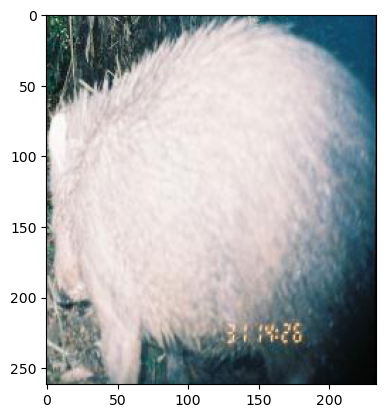

In [ ]:
img = df_tmp.iloc[l,:].sample(1)['cropped_image'].item()
plt.plot()
plt.imshow(img)
plt.show()

## Statistical Comparison of two best models

In [11]:
if COMPUTE_STATISTICAL_COMPARISON:
    all_file_names = df.loc[df['subset'].isin(['train', 'valid']), 'file_name'].values

    # Parameters for Repeated K-Fold
    n_splits = 5  # Number of splits for K-Fold
    n_repeats = 3  # Number of repetitions
    random_state = 0  # For reproducibility

    # Initialize Repeated K-Fold
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    l_val_acc_vit = []
    l_val_acc_efficientnet = []
    l_val_acc_simclr = []
    # Loop through each fold
    for repeat_idx, (train_index, valid_index) in enumerate(rkf.split(all_file_names)):
        train_files = all_file_names[train_index]
        valid_files = all_file_names[valid_index]

        df_train = df[df['file_name'].isin(train_files)]
        df_valid = df[df['file_name'].isin(valid_files)]

        df_train['u']=1
        df_valid['u']=1
        df_train['subset'] = 'train'
        df_train['subset'] = 'valid'
        df_balanced_rfk = pd.concat([
            df_undersampling_strat(df_train,subset_col='u',label_col='label'),
            df_undersampling_strat(df_valid,subset_col='u',label_col='label'),
            df_undersampling_strat(df[df['subset']=='test'],subset_col='u',label_col='label')
        ])

        # EfficienNet
        train_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','label'].to_list(),
            transform=train_transform_labeled
            )
        valid_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','label'].to_list(),
            transform=val_transform_labeled
            )
        test_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','label'].to_list(),
            transform=val_transform_labeled
            )
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=32,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        lightning_model = CNNLightningModule(learning_rate=0.0001,
                                                frozen_prop=0.15,
                                                model_name='efficientnet')
        results_list_1 = train_supervised_model(lightning_model,
                                            labeled_datamodule, 
                                            total_epochs=MAX_EPOCHS_SUPERVISED,
                                            model_name='efficientnet')

        # ViT
        train_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','label'].to_list(),
            transform=train_transform_labeled_vit
            )
        valid_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','label'].to_list(),
            transform=val_transform_labeled_vit
            )
        test_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','label'].to_list(),
            transform=val_transform_labeled_vit
            )
        lightning_model = ViTLightningModule(learning_rate=0.0001,
                                            frozen_prop=0)
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=64,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        results_list_2 = train_supervised_model(lightning_model,
                                            labeled_datamodule, 
                                            total_epochs=MAX_EPOCHS_SUPERVISED,
                                            model_name='vit')
        
        # SimCLR
        # Start lightning data module
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=32,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        train_loader_classifier = labeled_datamodule.train_dataloader()
        valid_loader_classifier = labeled_datamodule.val_dataloader()

        train_feats_simclr = prepare_data_features(simclr_model, train_loader_classifier)
        test_feats_simclr = prepare_data_features(simclr_model, valid_loader_classifier)

        sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
        _, small_set_results = train_logreg(batch_size=32,
                                            train_feats_data=sub_train_set,
                                            test_feats_data=test_feats_simclr,
                                            model_suffix=num_imgs_per_label,
                                            feature_dim=train_feats_simclr.tensors[0].shape[1],
                                            num_classes=2,
                                            lr=0.001,
                                            weight_decay=0.01)


        val_acc_vit = results_list_1[0][0]['val_acc']

        val_acc_efficientnet = results_list_2[0][0]['val_acc']

        val_acc_simclr = small_set_results['test']

    t_stat, t_pval = ttest_ind(l_val_acc_vit, l_val_acc_simclr)
    print(f"T-test ViT vs. SimCLR: t-statistic = {t_stat}, p-value = {t_pval}")
    t_stat, t_pval = ttest_ind(l_val_acc_vit, l_val_acc_efficientnet)
    print(f"T-test ViT vs. EfficientNet: t-statistic = {t_stat}, p-value = {t_pval}")

## Test Accuracy of best model

In [ ]:
vit_model = ViTLightningModule.load_from_checkpoint(all_results_list[0][63][2])
vit_model.to(torch.device("cuda"))
vit_model.eval()

train_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
    transform=train_transform_labeled_vit
    )
valid_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
    transform=val_transform_labeled_vit
    )
test_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
    transform=val_transform_labeled_vit
    )

# Start lightning data module
labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                valid_dataset_labeled, 
                                test_dataset_labeled, 
                                batch_size=64,
                                num_workers=NUM_WORKERS_SUPERVISED)

all_preds = []
all_labels = []

test_loader = labeled_datamodule.test_dataloader()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = vit_model(inputs.to(torch.device("cuda")))  # Forward pass
        preds = (outputs>0)*1
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

## EDA

### Supervised Models

In [37]:
df_grid['val_acc_max'] = df_grid.groupby(['model_name'])['val_acc'].transform('max')

df_grid[lambda x: x['val_acc'] == x['val_acc_max']].sort_values('val_acc')

,lr,batch_size,frozen_prop,model_name,val_acc,val_loss,val_precision,val_recall,train_time_minutes,val_acc_max
181,0.0001,32,0.15,vgg,0.856707,0.355021,0.510388,0.436179,15.200181,0.856707
150,0.0001,16,0.00,resnet,0.871951,0.333100,0.508130,0.452236,13.136107,0.871951
132,0.0005,64,0.15,efficientnet,0.892276,0.338450,0.540379,0.463211,21.254852,0.892276
179,0.0001,32,0.00,vit_large,0.908537,0.254013,0.510282,0.463008,34.270978,0.908537
183,0.0001,32,0.15,vit_base,0.909553,0.241100,0.510282,0.456911,10.509725,0.909553


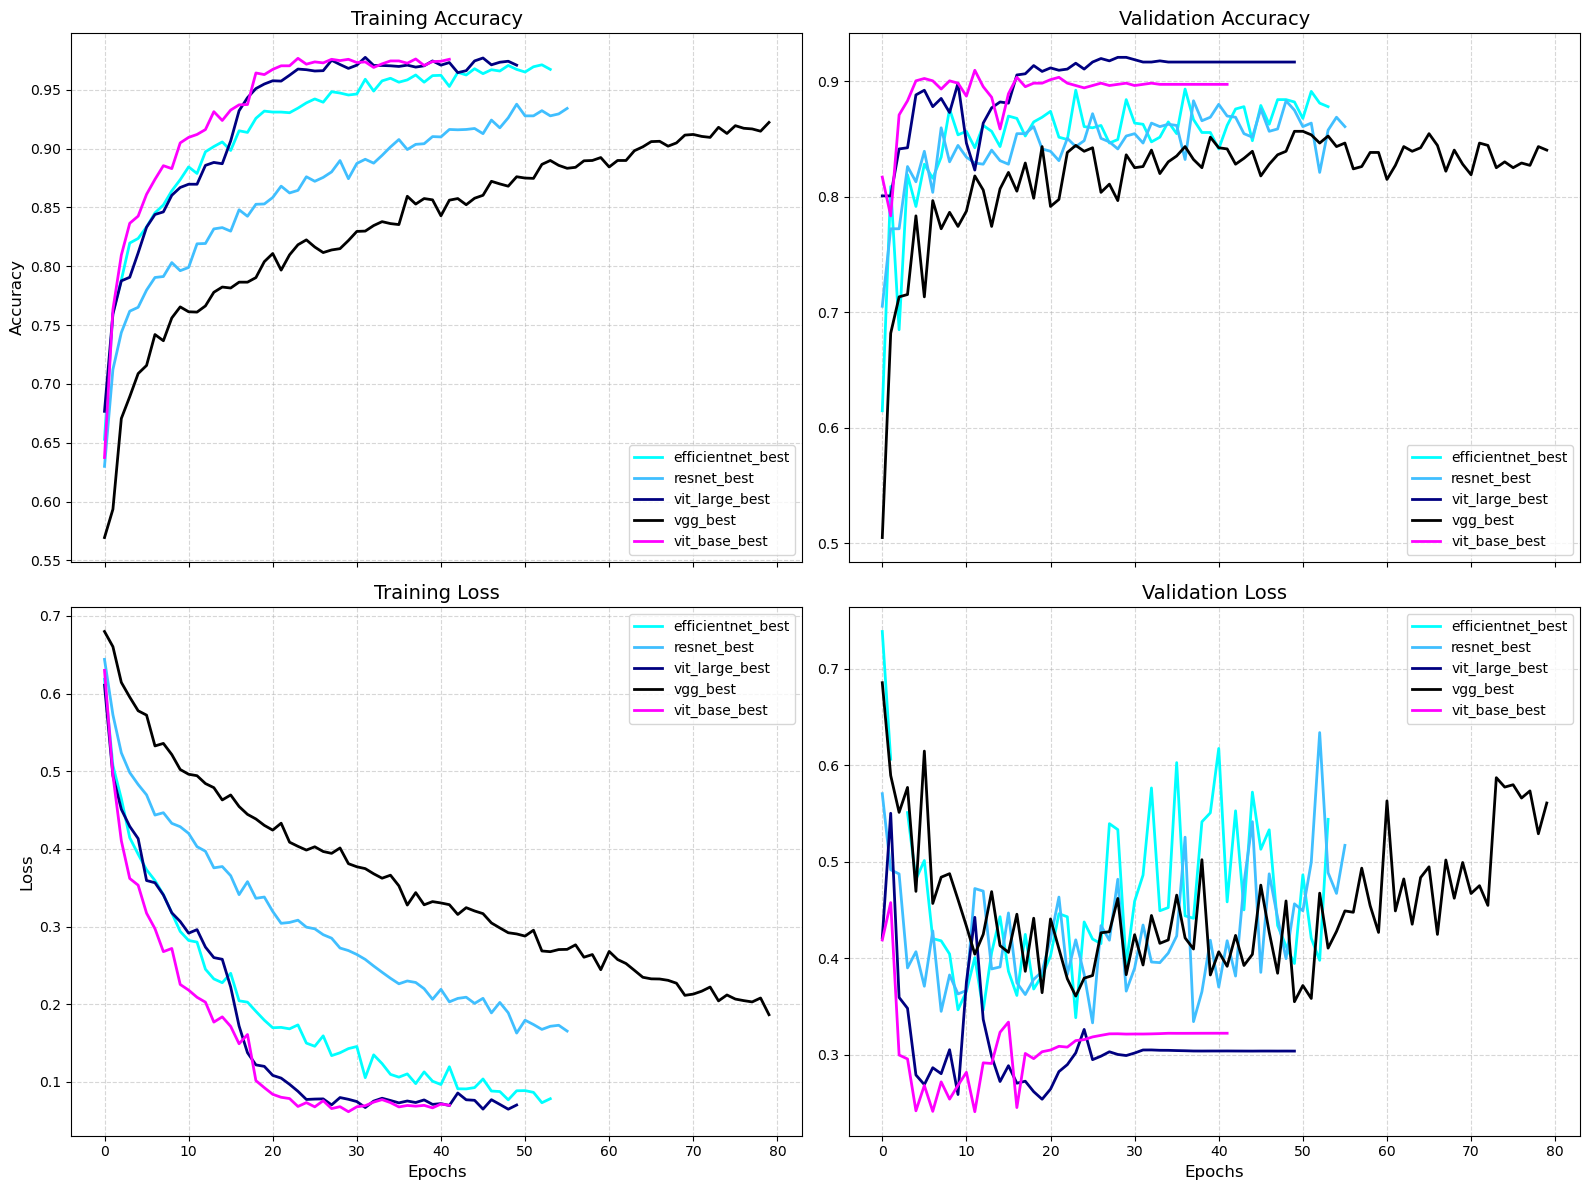

In [ ]:
# Compare training and validation loss, accuracy for best hp configuration of each sl model
index_list = df_grid[lambda x: x['val_acc'] == x['val_acc_max']].index
train_acc = {}
val_acc = {}
train_loss = {}
val_loss = {}

for i in index_list:
    res_i = all_results_list[i][1].groupby(['epoch']).max().reset_index()[['epoch','train_acc','train_loss','val_acc','val_loss']].dropna()
    res_i.loc[res_i['val_loss']>1,'val_loss'] = np.nan
    name_i = df_grid.loc[i, 'model_name']
    name_i = name_i + '_best'
    train_acc[name_i] = res_i['train_acc'].to_list()
    val_acc[name_i] = res_i['val_acc'].to_list()
    train_loss[name_i] = res_i['train_loss'].to_list()
    val_loss[name_i] = res_i['val_loss'].to_list()

# Define a color map ranging from blue to black
colors = cm.Blues(np.linspace(0.3, 0.8, 4))
colors = cm.ScalarMappable(cmap='cool').to_rgba(np.linspace(0.2, 1.0, 5))
colors[2] = [0., 0., 0.5, 1.] 
colors[3] = [0., 0., 0., 1.] 

# Plot the data with updated colors
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

# Plot training accuracy
for idx, (model, values) in enumerate(train_acc.items()):
    epochs = np.arange(len(values))
    axes[0, 0].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[0, 0].set_title("Training Accuracy", fontsize=14)
axes[0, 0].set_ylabel("Accuracy", fontsize=12)
axes[0, 0].grid(alpha=0.5, linestyle='--')
axes[0, 0].legend(fontsize=10)

# Plot validation accuracy
for idx, (model, values) in enumerate(val_acc.items()):
    epochs = np.arange(len(values))
    axes[0, 1].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[0, 1].set_title("Validation Accuracy", fontsize=14)
axes[0, 1].grid(alpha=0.5, linestyle='--')
axes[0, 1].legend(fontsize=10)

# Plot training loss
for idx, (model, values) in enumerate(train_loss.items()):
    epochs = np.arange(len(values))
    axes[1, 0].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[1, 0].set_title("Training Loss", fontsize=14)
axes[1, 0].set_xlabel("Epochs", fontsize=12)
axes[1, 0].set_ylabel("Loss", fontsize=12)
axes[1, 0].grid(alpha=0.5, linestyle='--')
axes[1, 0].legend(fontsize=10)

# Plot validation loss
for idx, (model, values) in enumerate(val_loss.items()):
    epochs = np.arange(len(values))
    axes[1, 1].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[1, 1].set_title("Validation Loss", fontsize=14)
axes[1, 1].set_xlabel("Epochs", fontsize=12)
axes[1, 1].grid(alpha=0.5, linestyle='--')
axes[1, 1].legend(fontsize=10)

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'best_supervised_training_comparison.png'), format="png", dpi=300)
plt.show()

In [15]:
df_grid['model_name'] = df_grid['model_name'].astype(str)
df_grid[['val_loss','val_acc']] = np.round(df_grid[['val_loss','val_acc']],4)
df_grid = df_grid[['model_name','lr','batch_size','frozen_prop','val_loss','val_acc','train_time_minutes']].sort_values(['model_name','lr','batch_size','frozen_prop']).reset_index(drop=True)
df_grid.columns = ['Model', 'Learning Rate', 'Batch Size', 'Frozen Layers Proportion', 'Validation Loss', 'Validation Accuracy', 'Training Time (Minutes)']
df_grid.loc[df_grid['Model']=='efficientnet','Model']='EfficientNet'
df_grid.loc[df_grid['Model']=='resnet','Model']='ResNet'
df_grid.loc[df_grid['Model']=='vgg','Model']='VGG'
df_grid.loc[df_grid['Model']=='vit_base','Model']='ViT-base'
df_grid.loc[df_grid['Model']=='vit_large','Model']='ViT-large'
display(df_grid)

,Model,Learning Rate,Batch Size,Frozen Layers Proportion,Validation Loss,Validation Accuracy,Training Time (Minutes)
0,EfficientNet,0.0001,16,0.00,0.3131,0.8496,23.359303
1,EfficientNet,0.0001,16,0.15,0.2954,0.8648,20.856651
2,EfficientNet,0.0001,16,0.50,0.3283,0.8537,13.597718
3,EfficientNet,0.0001,16,0.80,0.4284,0.7947,43.125620
4,EfficientNet,0.0001,16,0.95,0.5898,0.6860,49.253338
...,...,...,...,...,...,...,...
220,ViT-large,0.0010,64,0.00,0.6839,0.5854,21.763110
221,ViT-large,0.0010,64,0.15,0.6931,0.5000,18.339647
222,ViT-large,0.0010,64,0.50,0.3122,0.8750,27.565612
223,ViT-large,0.0010,64,0.80,0.3271,0.8628,15.203712


In [ ]:
df_grid_latex = df_grid.copy()
columns_to_format = ['Learning Rate', 'Validation Loss', 'Validation Accuracy'] 
decimal_places = 4
df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")

columns_to_format = ['Frozen Layers Proportion', 'Training Time (Minutes)'] 
decimal_places = 2
df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")

df_grid_latex[df_grid_latex['Learning Rate']!='0.0005'].drop(columns = ['val_acc_max','tmp']).to_latex(os.path.join(PATH_RESULTS_TABLES, 'supervised_grid_results.tex'), index=False)

/tmp/ipykernel_3134921/930065232.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")
/tmp/ipykernel_3134921/930065232.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")


### SimCLR

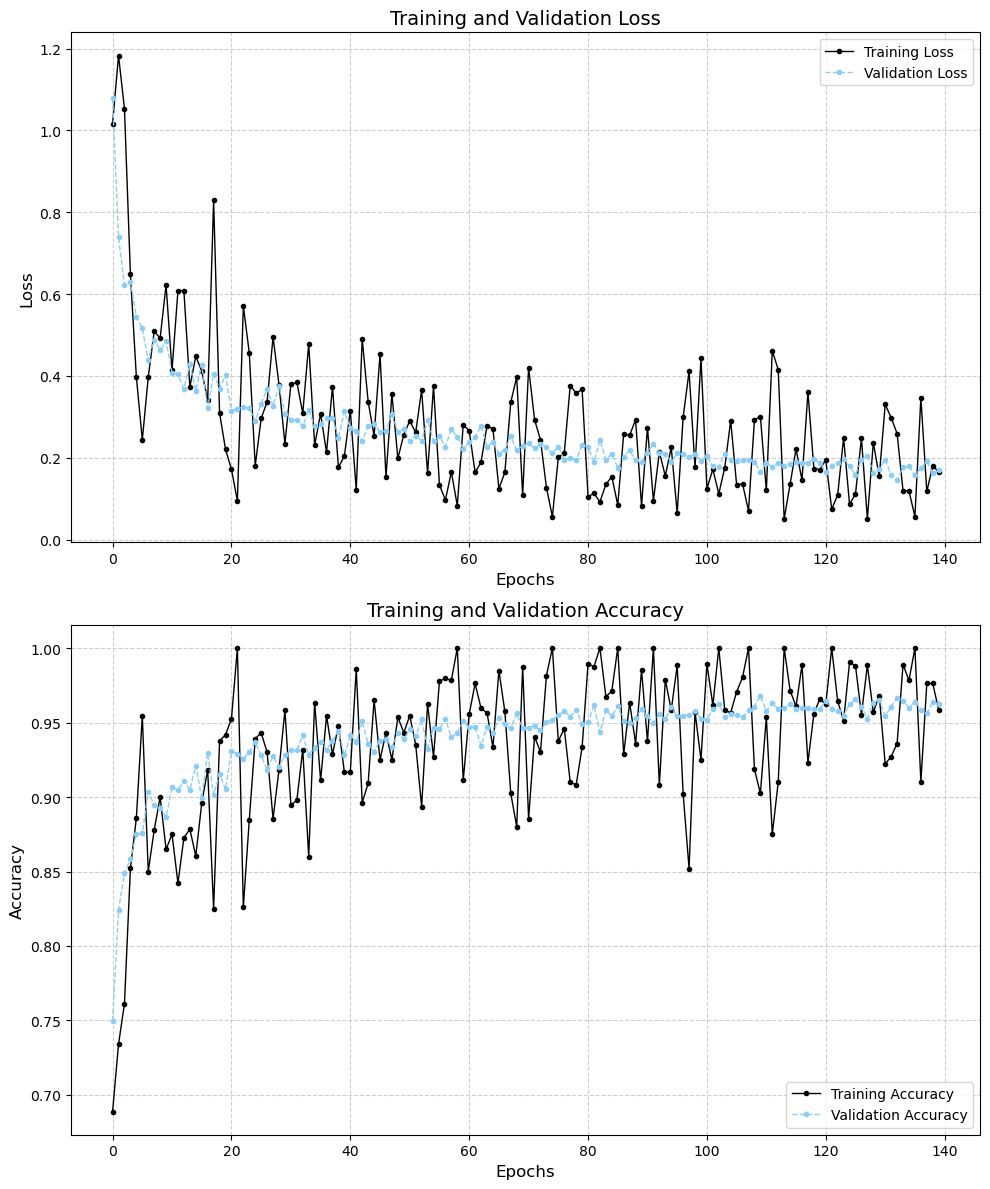

In [ ]:
# Encoder
## Training graph
dir_results_encoder_simclr = '/home/dvillacreses/code/outputs/vit_large_p16_bs256_hd32768_logs/train_simclr_resnet/version_0/metrics.csv'
df_encoder_simclr = pd.read_csv(dir_results_encoder_simclr)

cond_x = lambda x: ~x['train_acc_top1'].isna()
df_encoder_simclr.loc[cond_x, 'max_step'] = df_encoder_simclr[cond_x].groupby('epoch')['step'].transform("max")
cond_1 = lambda x: x['max_step'] == x['step']
cond_2 = lambda x: ~x['val_acc_top1'].isna()

df_encoder_simclr = pd.merge(
    left=df_encoder_simclr.loc[cond_1,['epoch','train_acc_top1','train_loss']],
    right=df_encoder_simclr.loc[cond_2,['epoch','val_acc_top1','val_loss']],
    on='epoch'
)

epochs = df_encoder_simclr['epoch']
train_loss = df_encoder_simclr['train_loss']
val_loss = df_encoder_simclr['val_loss']
train_acc = df_encoder_simclr['train_acc_top1']
val_acc = df_encoder_simclr['val_acc_top1']

## Graph
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

axes[0].plot(epochs, train_loss, label='Training Loss', marker='.', linestyle='-', linewidth=1, color = 'black')
axes[0].plot(epochs, val_loss, label='Validation Loss', marker='.', linestyle='--', linewidth=1, color = 'lightskyblue')
axes[0].set_title('Training and Validation Loss', fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(visible=True, linestyle='--', alpha=0.6)

axes[1].plot(epochs, train_acc, label='Training Accuracy', marker='.', linestyle='-', linewidth=1, color = 'black')
axes[1].plot(epochs, val_acc, label='Validation Accuracy', marker='.', linestyle='--', linewidth=1, color = 'lightskyblue')
axes[1].set_title('Training and Validation Accuracy', fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'simclr_encoder_training.png'), format="png", dpi=300)
plt.show()


In [ ]:
print(f"{df_encoder_simclr['train_acc_top1'].max()=}")
print(f"{df_encoder_simclr['val_acc_top1'].max()=}")

# df_encoder_simclr['train_acc_top1'].max()=0.96875
# df_encoder_simclr['val_acc_top1'].max()=0.901223599910736

### All models

In [72]:
df_grid['Learning Rate'].value_counts()

Learning Rate
0.0001    75
0.0005    75
0.0010    75
Name: count, dtype: int64

0 EfficientNet
1 ResNet
2 VGG
3 ViT-base
4 ViT-large


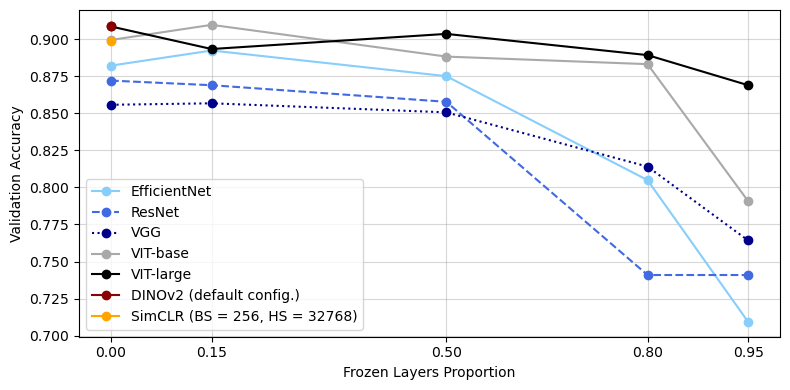

In [ ]:
# Summary graph of supervised and SimCLR
df_grid['val_acc_max'] = df_grid.groupby('Model')['Validation Accuracy'].transform('max')

filter_dict = {}
for i, key in enumerate(['EfficientNet','ResNet','VGG','ViT-base','ViT-large']):
    filter_dict[key] = df_grid.loc[lambda x: (x['Validation Accuracy'] == x['val_acc_max']) & (x['Model']==key),:].iloc[:,[0,1,2,5]].to_dict()
    print(i, key)


## Data
df_grid['tmp'] = df_grid.groupby(['Model','Frozen Layers Proportion'])['Validation Accuracy'].transform('max')

frozen_layers = df_grid.drop_duplicates('Frozen Layers Proportion').sort_values('Frozen Layers Proportion').reset_index(drop=True)['Frozen Layers Proportion'].unique()
efficientnet_acc = df_grid[lambda x: (x['Model']=='EfficientNet') & (x['tmp']==x['Validation Accuracy'])].drop_duplicates('Frozen Layers Proportion').sort_values('Frozen Layers Proportion').reset_index(drop=True)['Validation Accuracy']
resnet_acc = df_grid[lambda x: (x['Model']=='ResNet') & (x['tmp']==x['Validation Accuracy'])].drop_duplicates('Frozen Layers Proportion').sort_values('Frozen Layers Proportion').reset_index(drop=True)['Validation Accuracy']
bgg_acc = df_grid[lambda x: (x['Model']=='VGG') & (x['tmp']==x['Validation Accuracy'])].drop_duplicates('Frozen Layers Proportion').sort_values('Frozen Layers Proportion').reset_index(drop=True)['Validation Accuracy']
vit_base_acc = df_grid[lambda x: (x['Model']=='ViT-base') & (x['tmp']==x['Validation Accuracy'])].drop_duplicates('Frozen Layers Proportion').sort_values('Frozen Layers Proportion').reset_index(drop=True)['Validation Accuracy']
vit_large_acc = df_grid[lambda x: (x['Model']=='ViT-large') & (x['tmp']==x['Validation Accuracy'])].drop_duplicates('Frozen Layers Proportion').sort_values('Frozen Layers Proportion').reset_index(drop=True)['Validation Accuracy']


## Plot
plt.figure(figsize=(8, 4))

plt.plot(frozen_layers, 
         efficientnet_acc.to_list(), 
         #label=f"{filter_dict['EfficientNet']['Model']} (LR={filter_dict['EfficientNet']['Learning Rate']}, BS={filter_dict['EfficientNet']['Batch Size']})", 
         label = 'EfficientNet',
         marker='o', 
         color='lightskyblue')
plt.plot(frozen_layers, 
         resnet_acc.to_list(), 
         #label=f"{filter_dict['ResNet']['Model']} (LR={filter_dict['ResNet']['Learning Rate']}, BS={filter_dict['ResNet']['Batch Size']})", 
         label = 'ResNet',
         marker='o', 
         color='royalblue', 
         linestyle='--')
plt.plot(frozen_layers, 
         bgg_acc.to_list(), 
         #label=f"{filter_dict['VGG']['Model']} (LR={filter_dict['VGG']['Learning Rate']}, BS={filter_dict['VGG']['Batch Size']})", 
         label = 'VGG',
         marker='o', 
         color='darkblue', 
         linestyle=':')
plt.plot(frozen_layers, 
         vit_base_acc.to_list(), 
         #label=f"{filter_dict['ViT-base']['Model']} (LR={filter_dict['ViT-base']['Learning Rate']}, BS={filter_dict['ViT-base']['Batch Size']})", 
         label = 'VIT-base',
         marker='o', 
         color='darkgrey')
plt.plot(frozen_layers, 
         vit_large_acc.to_list(), 
         #label=f"{filter_dict['ViT-large']['Model']} (LR={filter_dict['ViT-base']['Learning Rate']}, BS={filter_dict['ViT-base']['Batch Size']})", 
         label = 'VIT-large',
         marker='o', 
         color='black')


plt.plot(frozen_layers, 
         [0.909,None,None,None,None], 
         label=f"DINOv2 (default config.)", 
         marker='o', 
         color='darkred')
plt.plot(frozen_layers, 
         [0.899,None,None,None,None], 
         label=f"SimCLR (BS = 256, HS = 32768)", 
         marker='o', 
         color='orange')

plt.xlabel('Frozen Layers Proportion')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.5)
plt.xticks(frozen_layers)
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'summary_best_models.png'), format="png", dpi=300)
plt.show()

### t-SNE for embeddings

In [ ]:
# Get Embedding from SimCLR
train_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
    transform=val_transform_labeled_simclr
    )
valid_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
    transform=val_transform_labeled_simclr
    )
test_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
    transform=val_transform_labeled_simclr
    )

labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                    valid_dataset_labeled, 
                                    test_dataset_labeled, 
                                    batch_size=32,
                                    num_workers=NUM_WORKERS_SUPERVISED)
valid_loader_classifier = labeled_datamodule.val_dataloader()

valid_feats_simclr = prepare_data_features(simclr_model, valid_loader_classifier)

## From Features for Classifier from SimCLR compute t-SNE
standard_scaler = StandardScaler()
tsne = TSNE(n_components=2, random_state=0, max_iter=10_000)
embeddings_tsne_simclr = tsne.fit_transform(standard_scaler.fit_transform(valid_feats_simclr.tensors[0]))

# Get Embeddings from best ViT
vit_model = ViTLightningModule.load_from_checkpoint(all_results_list[0][63][2])
vit_model = vit_model.to(torch.device("cpu"))
embedding_extractor = EmbeddingExtractor_VIT(vit_model, layer_idx=-1, use_cls_token=True)

valid_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
    transform=val_transform_labeled_vit
    )
val_loader = LabeledDataModule(valid_dataset_labeled,
                               valid_dataset_labeled,
                               valid_dataset_labeled,
                               batch_size=984,
                               num_workers=os.cpu_count()).val_dataloader()
val_toch = next(iter(val_loader))[0].to('cpu')
embeddings_vit = embedding_extractor(val_toch)
embeddings_tsne_vit = tsne.fit_transform(standard_scaler.fit_transform(embeddings_vit.detach().numpy()))

In [ ]:
# Define colors and labels
colors = {0: "black", 1: "dodgerblue"}
labels = {0: "Taypec", 1: "Taytaj"}

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 12))  # 1 row, 2 columns

# Plot SimCLR data
for class_label in [0, 1]:
    axes[0].scatter(
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )
axes[0].set_title("SimCLR")
axes[0].set_xlabel("t-SNE Dimension 1")
axes[0].set_ylabel("t-SNE Dimension 2")
axes[0].legend()

# Plot ViT data
for class_label in [0, 1]:
    axes[1].scatter(
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )
axes[1].set_title("ViT")
axes[1].set_xlabel("t-SNE Dimension 1")
axes[1].set_ylabel("t-SNE Dimension 2")
axes[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'embedding_best_models.eps'), format="eps", dpi=600)
plt.show()

In [ ]:
# Define colors and labels
colors = {0: "black", 1: "dodgerblue"}
labels = {0: "Taypec", 1: "Taytaj"}

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot SimCLR data
for class_label in [0, 1]:
    axes[0].scatter(
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )
axes[0].set_title("SimCLR")
axes[0].set_xlabel("t-SNE Dimension 1")
axes[0].set_ylabel("t-SNE Dimension 2")
axes[0].legend()

# Plot ViT data
for class_label in [0, 1]:
    axes[1].scatter(
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )
axes[1].set_title("ViT")
axes[1].set_xlabel("t-SNE Dimension 1")
axes[1].set_ylabel("t-SNE Dimension 2")
axes[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'embedding_best_models_v2.eps'), format="eps", dpi=600)
plt.show()

In [ ]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes

# Plot ViT data
for class_label in [0, 1]:
    ax.scatter(
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )

# Set title and labels
ax.set_title("ViT")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS, 'embedding_best_models_v3.eps'), format="eps", dpi=600)
plt.show()

In [ ]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes

# Plot ViT data
for class_label in [0, 1]:
    ax.scatter(
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )
ax.set_title("SimCLR")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS, 'embedding_best_models_v4.eps'), format="eps", dpi=600)
plt.show()

### Individual images for specific areas of t-SNE

In [ ]:
inertia = []
cluster_range = range(1, 41)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(np.hstack([embeddings_tsne_vit, np.array(valid_feats_simclr.tensors[1]).reshape(984,1)]))
    inertia.append(kmeans.inertia_)

## labels 
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(np.hstack([embeddings_tsne_vit, np.array(valid_feats_simclr.tensors[1]).reshape(984,1)]))

labels = kmeans.labels_ 

## Elbow Method graph
fig, axes = plt.subplots(figsize=(8, 6))
### Subplot 1: Elbow Method
axes.plot(cluster_range, inertia, marker='o', linestyle='--', color = 'black')
axes.set_title('Elbow Method for Optimal k')
axes.set_xlabel('Number of Clusters (k)')
axes.set_ylabel('Inertia (Sum of Squared Distances)')
axes.grid()

plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'cluster_graphs_v1.eps'), format="eps", dpi=600)
plt.show()

In [ ]:
## labels 
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(np.hstack([embeddings_tsne_vit, np.array(valid_feats_simclr.tensors[1]).reshape(984,1)]))

labels = kmeans.labels_ 

fig, axes = plt.subplots(figsize=(10, 8))
scatter_colors = [colors[i % len(colors)] for i in range(n_clusters)]
for class_label in range(n_clusters):
    cluster_data = embeddings_tsne_vit[labels == class_label]
    axes.scatter(
        cluster_data[:, 0],
        cluster_data[:, 1],
        label=f'Cluster {class_label}',
        s=50
    )
axes.set_title('Clusters Visualization')
axes.set_xlabel("t-SNE Dimension 1")
axes.set_ylabel("t-SNE Dimension 2")
axes.legend()
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'cluster_graphs_v2.eps'), format="eps", dpi=600)
plt.show()

In [ ]:
# k-means over best model embeddings
inertia = []
cluster_range = range(1, 41)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(np.hstack([embeddings_tsne_vit, np.array(valid_feats_simclr.tensors[1]).reshape(984,1)]))
    inertia.append(kmeans.inertia_)

## labels 
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(np.hstack([embeddings_tsne_vit, np.array(valid_feats_simclr.tensors[1]).reshape(984,1)]))

labels = kmeans.labels_ 

## Elbow Method graph and t-SNE with cluster colored
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
### Subplot 1: Elbow Method
axes[0].plot(cluster_range, inertia, marker='o', linestyle='--', color = 'black')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Sum of Squared Distances)')
axes[0].grid()

### Subplot 2: Scatter plot of clustered data
colors = [
    '#4C566A',  # Slate Gray
    '#81A1C1',  # Soft Blue
    '#88C0D0',  # Light Cyan
    '#5E81AC',  # Steel Blue
    '#000000',  # black
    '#A3BE8C',  # Sage Green
    '#B48EAD',  # Dusty Lavender
    '#D08770',  # Muted Orange
    '#EBCB8B',  # Sand Yellow
    '#BF616A',  # Soft Red
    '#006400',  # Dark Green
    '#301934',  # Dark Purple
    '#6F4E37',  # Coffee Brown
    '#D8DEE9'   # Light Gray-Blue
]
scatter_colors = [colors[i % len(colors)] for i in range(n_clusters)]
for class_label in range(n_clusters):
    cluster_data = embeddings_tsne_vit[labels == class_label]
    axes[1].scatter(
        cluster_data[:, 0],
        cluster_data[:, 1],
        label=f'Cluster {class_label}',
        color=scatter_colors[class_label],
        s=50
    )
axes[1].set_title('Clusters Visualization')
axes[1].set_xlabel("t-SNE Dimension 1")
axes[1].set_ylabel("t-SNE Dimension 2")
axes[1].legend()
plt.tight_layout()
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'cluster_graphs.eps'), format="eps", dpi=600)
plt.show()

## Individual Images per selected cluster
clusters_to_display = [5, 0, 2, 12, 6]
images_per_cluster = 5
random.seed(1)
fig = plt.figure(figsize=(12, 10))
#fig.suptitle('Sample Images from Selected Clusters', fontsize=20, weight='bold')
gs = GridSpec(len(clusters_to_display), images_per_cluster + 1, width_ratios=[0.5] + [1] * images_per_cluster)
for i, cluster in enumerate(clusters_to_display):
    ax_label = fig.add_subplot(gs[i, 0])
    ax_label.text(
        0.5, 0.5, f'Cluster {cluster}',
        fontsize=14, weight='bold', rotation=0,
        ha='center', va='center'
    )
    ax_label.axis('off')  # Hide axes for the label
    # Get indices of images belonging to the current cluster
    cluster_indices = list(np.where(labels == cluster)[0])
    selected_indices = random.sample(cluster_indices, images_per_cluster)
    for j, idx in enumerate(selected_indices):
        # Add image plots
        ax = fig.add_subplot(gs[i, j + 1])
        image = val_toch[idx].permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        # Normalize image to [0, 1] range for visualization
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image)
        ax.axis('off')
plt.tight_layout() # Avoid innecesary spaces in graph
#plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'selected_images_cluster_graph.eps'), format="eps", dpi=600)
plt.savefig(os.path.join(PATH_RESULTS_GRAPHS,'selected_images_cluster_graph.png'), dpi=600)
plt.show()

In [ ]:
## Individual Images per selected cluster
clusters_to_display = [5, 0, 2, 12, 6]
images_per_cluster = 5
#random.seed(1)
fig = plt.figure(figsize=(12, 10))
#fig.suptitle('Sample Images from Selected Clusters', fontsize=20, weight='bold')
gs = GridSpec(len(clusters_to_display), images_per_cluster + 1, width_ratios=[0.5] + [1] * images_per_cluster)
for i, cluster in enumerate(clusters_to_display):
    ax_label = fig.add_subplot(gs[i, 0])
    ax_label.text(
        0.5, 0.5, f'Cluster {cluster}',
        fontsize=14, weight='bold', rotation=0,
        ha='center', va='center'
    )
    ax_label.axis('off')  # Hide axes for the label
    # Get indices of images belonging to the current cluster
    cluster_indices = list(np.where(labels == cluster)[0])
    selected_indices = random.sample(cluster_indices, images_per_cluster)
    for j, idx in enumerate(selected_indices):
        # Add image plots
        ax = fig.add_subplot(gs[i, j + 1])
        image = val_toch[idx].permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        # Normalize image to [0, 1] range for visualization
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image)
        ax.axis('off')
plt.tight_layout()
plt.show()